In [ ]:
import sys
sys.path.append('../')

In [ ]:
from rumboost.utils import *
from rumboost.utility_smoothing import *
from rumboost.rumboost import *
from rumboost.dataset import *
from rumboost.models import *
from rumboost.utility_plotting import *
from rumboost.post_process import *

import lightgbm

# Example: Functional effect model (correlation amongst observations)

This notebook shows features implemented in RUMBoost through an example on the LPMC dataset, a mode choice dataset in London developed Hillel et al. (2018). You can find the original source of data [here](https://www.icevirtuallibrary.com/doi/suppl/10.1680/jsmic.17.00018) and the original paper [here](https://www.icevirtuallibrary.com/doi/full/10.1680/jsmic.17.00018).

We first load the preprocessed dataset and its folds for cross-validation. You can find the data under the Data folder

In [ ]:
#load dataset
LPMC_train, LPMC_test, folds = load_preprocess_LPMC()

#load model
LPMC_model = LPMC(LPMC_train)

## Functional effect model

We also present the functional effect model, inspired from the Mixed Effect models. We create two ensembles where one contains the attributes with no interaction, and another one contains the socio-economic characteristics, with no interaction restrictions. The only thing that needs to be updated is the ```rum_structure``` dictionary where there are now ```2*num_classes``` dictionaries in the list.

```rum_structure``` follows this form: ```[dictionary_alt_0_without_interaction, dictionary_alt_0_with_interactions, dictionary_alt_1_without_interactions, ...]```

It can be manually specified, or using the ```bio_to_rumboost()``` function with the ```fct_effect_variables``` argument.

In addition, a set of parameters ```params_fe``` to apply on the ensembles with full interaction needs to be specified in the argument of the ```rum_train``` function

In [ ]:
fct_effect_variables = ['age', 'female', 'start_time_linear', 'travel_day', 'day_of_week', 'car_ownership', 'driving_license', 'purpose_B', 'purpose_HBE', 'purpose_HBO', 'purpose_HBW', 'purpose_NHBO', 'fueltype_Average', 'fueltype_Diesel', 'fueltype_Hybrid', 'fueltype_Petrol']

rum_structure = bio_to_rumboost(LPMC_model, fct_effect_variables=fct_effect_variables)
rum_structure

### Hyperparameter search

Since the second part of the model has full feature interactions, we need to regularise it. Therefore we can conduct a hyperparameter search on the parameters of the second part of the model with hyperopt (mode details [here](https://hyperopt.github.io/hyperopt/).).
We won't run the full hyperparameter search, but we did run this code with 100 iterations for the paper.

In [ ]:
import hyperopt

_, _, folds = load_preprocess_LPMC()

param_space =  {'learning_rate': hyperopt.hp.choice('learning_rate', [0.1]),
                'num_leaves': hyperopt.pyll.scope.int(hyperopt.hp.quniform('num_leaves', 2, 100, 1)),
                'min_gain_to_split':  hyperopt.hp.loguniform('min_gain_to_split', -9.21, 1.61), # interval: [0.0001, 5]
                'min_sum_hessian_in_leaf': hyperopt.hp.loguniform('min_sum_hessian_in_leaf', 0, 4.6),
                'min_data_in_leaf': hyperopt.pyll.scope.int(hyperopt.hp.quniform('min_data_in_leaf', 1, 200, 1)),
                'bagging_fraction': hyperopt.hp.uniform('bagging_fraction', 0.5, 1),
                'bagging_freq': hyperopt.hp.choice('bagging_freq', [0, 1, 5, 10]),
                'feature_fraction': hyperopt.hp.uniform('feature_fraction', 0.5, 1),
                'lambda_l1': hyperopt.hp.loguniform('lambda_l1', -9.21, 2.30), # interval: [0.0001, 10]
                'lambda_l2': hyperopt.hp.loguniform('lambda_l2', -9.21, 2.30), # interval: [0.0001, 10]
                'max_bin': hyperopt.pyll.scope.int(hyperopt.hp.quniform('max_bin', 100, 500, 1))
                            }

STATIC_PARAMS = {'n_jobs': -1,
                'num_classes':4,
                'objective':'multiclass',
                'boosting': 'gbdt',
                'monotone_constraints_method': 'advanced',
                'verbosity': -1,
                'early_stopping_round':100,
                'num_iterations': 3000
                }

#features and label column names
features = [f for f in LPMC_train.columns if f != "choice"]
label = "choice"

#create lightgbm dataset
lgb_train_set = lightgbm.Dataset(LPMC_train[features], label=LPMC_train[label], free_raw_data=False)
lgb_test_set = lightgbm.Dataset(LPMC_test[features], label=LPMC_test[label], free_raw_data=False)

def objective(space):
    
    params = {'verbosity': -1,
    'num_classes':4,
    'early_stopping_round':100,
    'learning_rate': space['learning_rate'],
    'max_depth': 1,
    #'num_leaves':31,
    'num_boost_round': 3000,
    'objective':'multiclass',
    'boosting': 'gbdt',
    'monotone_constraints_method': 'advanced'}
    params_fe = {**space, **STATIC_PARAMS}

        # Applying k-Fold Cross Validation
    loss = 0
    N_sum = 0

    for train_idx, test_idx in folds:
        # Obtain training and testing data for this iteration (split of de k-Fold)
        train_set = lgb_train_set.subset(sorted(train_idx))
        test_set = lgb_train_set.subset(sorted(test_idx))

        clf_trained = rum_train(params, train_set, rum_structure, valid_sets=[test_set], params_fe=params_fe)

        proba = clf_trained.predict(test_set)

        # Cross-Entropy Loss
        sum = 0
        i = 0
        for sel_mode in test_set.get_label():
            sum = sum + np.log(proba[i,int(sel_mode)])
            i += 1
        N = i - 1
        loss += -sum  # Original: (-sum/N) * N
        N_sum += N

    loss = loss / N_sum
    return {'loss': loss, 'status': hyperopt.STATUS_OK, 'best_iteration': clf_trained.best_iteration}


#%%
#n_iter = 100
n_iter = 1
# Read a previous adjusted-hyperparameters datafile or create a new one

trials = hyperopt.Trials()
best_classifier = hyperopt.fmin(fn=objective,
                                space=param_space,
                                algo=hyperopt.tpe.suggest,
                                max_evals=n_iter,
                                trials=trials)

print(f'Best negative CE: {trials.best_trial["result"]["loss"]}')


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basi

Early stopping at iteration 1251, with a best score on test set of 0.6454486526957377, and on train set of 0.6042533670346607
Finished loading model, total used 1352 iterations   
Finished loading model, total used 141 iterations    
Finished loading model, total used 1352 iterations   
Finished loading model, total used 136 iterations    
Finished loading model, total used 1352 iterations   
Finished loading model, total used 167 iterations    
Finished loading model, total used 1352 iterations   
Finished loading model, total used 177 iterations    
  0%|          | 0/1 [00:16<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basi

Early stopping at iteration 893, with a best score on test set of 0.6302918556697563, and on train set of 0.6096794185154071
Finished loading model, total used 994 iterations    
Finished loading model, total used 147 iterations    
Finished loading model, total used 994 iterations    
Finished loading model, total used 79 iterations     
Finished loading model, total used 994 iterations    
Finished loading model, total used 149 iterations    
Finished loading model, total used 994 iterations    
Finished loading model, total used 169 iterations    
  0%|          | 0/1 [00:28<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basi

Early stopping at iteration 811, with a best score on test set of 0.6499427595124949, and on train set of 0.6020655160103751
Finished loading model, total used 912 iterations    
Finished loading model, total used 176 iterations    
Finished loading model, total used 912 iterations    
Finished loading model, total used 114 iterations    
Finished loading model, total used 912 iterations    
Finished loading model, total used 168 iterations    
Finished loading model, total used 912 iterations    
Finished loading model, total used 172 iterations    
  0%|          | 0/1 [00:39<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basi

Early stopping at iteration 972, with a best score on test set of 0.6490321117110754, and on train set of 0.6022752400947645
Finished loading model, total used 1073 iterations   
Finished loading model, total used 159 iterations    
Finished loading model, total used 1073 iterations   
Finished loading model, total used 103 iterations    
Finished loading model, total used 1073 iterations   
Finished loading model, total used 166 iterations    
Finished loading model, total used 1073 iterations   
Finished loading model, total used 225 iterations    
  0%|          | 0/1 [00:52<?, ?trial/s, best loss=?]

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')

c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basi

Early stopping at iteration 806, with a best score on test set of 0.6515539389129131, and on train set of 0.6028902823256596
Finished loading model, total used 907 iterations    
Finished loading model, total used 148 iterations    
Finished loading model, total used 907 iterations    
Finished loading model, total used 92 iterations     
Finished loading model, total used 907 iterations    
Finished loading model, total used 179 iterations    
Finished loading model, total used 907 iterations    
Finished loading model, total used 197 iterations    
100%|██████████| 1/1 [01:03<00:00, 63.35s/trial, best loss: 0.645342817333636]
Best negative CE: 0.645342817333636


### Cross-validation with already computed optimal hyperparameters

Now that we have the optimal hyperparameters (taken from a previous run), we can run CV to obtain the optimal number of trees.

In [ ]:
_, _, folds = load_preprocess_LPMC()
params = {'n_jobs': -1,
          'num_classes':4,
          'objective':'multiclass',
          'boosting': 'gbdt',
          'monotone_constraints_method': 'advanced',
          'verbosity': -1,
          'num_iterations':3000,
          'early_stopping_round':100,
          'learning_rate':0.1,
          'max_depth':1
          }

optimal_params_fe = {'learning_rate':0.1,
                'num_leaves': 74,
                'min_gain_to_split': 0.8003177141507178,
                'min_sum_hessian_in_leaf': 1.7832435538908582,
                'min_data_in_leaf': 27,
                'bagging_fraction': 0.7002428082063967,
                'bagging_freq': 10,
                'feature_fraction': 0.8666540515437967,
                'lambda_l1': 6.591757385667399,
                'lambda_l2': 1.027567442472481,
                'max_bin': 131
                            }

ce_loss = 0
num_trees = 0

for i, (train_idx, test_idx) in enumerate(folds):
    #train and validation set
    train_set = lgb_train_set.subset(sorted(train_idx))
    test_set = lgb_train_set.subset(sorted(test_idx))

    #deep copy of params
    param = copy.deepcopy(params)

    print('-'*50 + '\n')
    print(f'Iteration {i+1}')

    #train model with functional effect parameters
    LPMC_model_trained = rum_train(param,train_set,rum_structure=rum_structure, valid_sets = [test_set], params_fe=optimal_params_fe)

    #aggregate results
    ce_loss += LPMC_model_trained.best_score
    num_trees += LPMC_model_trained.best_iteration
    
    print('-'*50 + '\n')
    print(f'Best cross entropy loss: {LPMC_model_trained.best_score}')
    print(f'Best number of trees: {LPMC_model_trained.best_iteration}')

ce_loss = ce_loss/5
num_trees = num_trees/5
print('-'*50 + '\n')
print(f'Cross validation negative cross entropy loss: {ce_loss}')
print(f'With a number of trees on average of {num_trees}')

--------------------------------------------------

Iteration 1


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:

Early stopping at iteration 926, with a best score on test set of 0.6446090721289347, and on train set of 0.6068617625947127
Finished loading model, total used 1027 iterations
Finished loading model, total used 155 iterations
Finished loading model, total used 1027 iterations
Finished loading model, total used 106 iterations
Finished loading model, total used 1027 iterations
Finished loading model, total used 243 iterations
Finished loading model, total used 1027 iterations
Finished loading model, total used 222 iterations
--------------------------------------------------

Best cross entropy loss: 0.6446090721289347
Best number of trees: 926
--------------------------------------------------

Iteration 2


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:

Early stopping at iteration 854, with a best score on test set of 0.6255357296736198, and on train set of 0.6111764925779694
Finished loading model, total used 955 iterations
Finished loading model, total used 164 iterations
Finished loading model, total used 955 iterations
Finished loading model, total used 89 iterations
Finished loading model, total used 955 iterations
Finished loading model, total used 258 iterations
Finished loading model, total used 955 iterations
Finished loading model, total used 182 iterations
--------------------------------------------------

Best cross entropy loss: 0.6255357296736198
Best number of trees: 854
--------------------------------------------------

Iteration 3


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:

Early stopping at iteration 771, with a best score on test set of 0.6477513809305059, and on train set of 0.6043210880579042
Finished loading model, total used 872 iterations
Finished loading model, total used 199 iterations
Finished loading model, total used 872 iterations
Finished loading model, total used 107 iterations
Finished loading model, total used 872 iterations
Finished loading model, total used 229 iterations
Finished loading model, total used 872 iterations
Finished loading model, total used 179 iterations
--------------------------------------------------

Best cross entropy loss: 0.6477513809305059
Best number of trees: 771
--------------------------------------------------

Iteration 4


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:

Early stopping at iteration 1774, with a best score on test set of 0.6463650094840885, and on train set of 0.6032431086985517
Finished loading model, total used 1875 iterations
Finished loading model, total used 207 iterations
Finished loading model, total used 1875 iterations
Finished loading model, total used 139 iterations
Finished loading model, total used 1875 iterations
Finished loading model, total used 218 iterations
Finished loading model, total used 1875 iterations
Finished loading model, total used 252 iterations
--------------------------------------------------

Best cross entropy loss: 0.6463650094840885
Best number of trees: 1774
--------------------------------------------------

Iteration 5


c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\ucesnjs\anaconda32\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:

Early stopping at iteration 558, with a best score on test set of 0.6490161142689254, and on train set of 0.6070754687880728
Finished loading model, total used 659 iterations
Finished loading model, total used 194 iterations
Finished loading model, total used 659 iterations
Finished loading model, total used 97 iterations
Finished loading model, total used 659 iterations
Finished loading model, total used 231 iterations
Finished loading model, total used 659 iterations
Finished loading model, total used 193 iterations
--------------------------------------------------

Best cross entropy loss: 0.6490161142689254
Best number of trees: 558
--------------------------------------------------

Cross validation negative cross entropy loss: 0.6426554612972148
With a number of trees on average of 976.6


### Testing the model on out-of-sample data

Now that we have the optimal number of trees (977), we can train the final version of the model on the full dataset, and test it on out-of-sample data with the ```predict()``` function. Note that the dataset must be a lightgbm object in the ```predict()``` function.

In [ ]:
rum_structure = bio_to_rumboost(LPMC_model, fct_effect_variables=fct_effect_variables)
params = {'n_jobs': -1,
          'num_classes':4,
          'objective':'multiclass',
          'boosting': 'gbdt',
          'monotone_constraints_method': 'advanced',
          'verbosity': -1,
          'num_iterations':977,
          #'early_stopping_round':100,
          'learning_rate':0.1,
          'max_depth':1
          }

LPMCFE_model_fully_trained = rum_train(params, lgb_train_set, rum_structure, params_fe=optimal_params_fe)

preds = LPMCFE_model_fully_trained.predict(lgb_test_set)

ce_test = cross_entropy(preds, lgb_test_set.get_label().astype(int))

print('-'*50)
print(f'Final negative cross-entropy on the test set: {ce_test}')

c:\Users\ucesnjs\OneDrive - University College London\Documents\PhD - UCL\rumboost\example\..\rumboost\rumboost.py:825: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Finished loading model, total used 977 iterations
Finished loading model, total used 133 iterations
Finished loading model, total used 977 iterations
Finished loading model, total used 86 iterations
Finished loading model, total used 977 iterations
Finished loading model, total used 288 iterations
Finished loading model, total used 977 iterations
Finished loading model, total used 308 iterations
--------------------------------------------------
Final negative cross-entropy on the test set: 0.6620119239324455


### Separation of the two models, and individual-specific constant

We can retrieve the two part of the model with the ```split_fe_model()``` function and plot the individual-specific constant resulting of the full interaction of the socio-economic characteristics with the function ```plot_ind_spec_constant()```. The attribute part can be used to plot the attribute utility just like in a classic RUMBoost model, and can be smoothed and lead to VoT.

In [ ]:
attributes_model, socec_model = split_fe_model(LPMCFE_model_fully_trained)

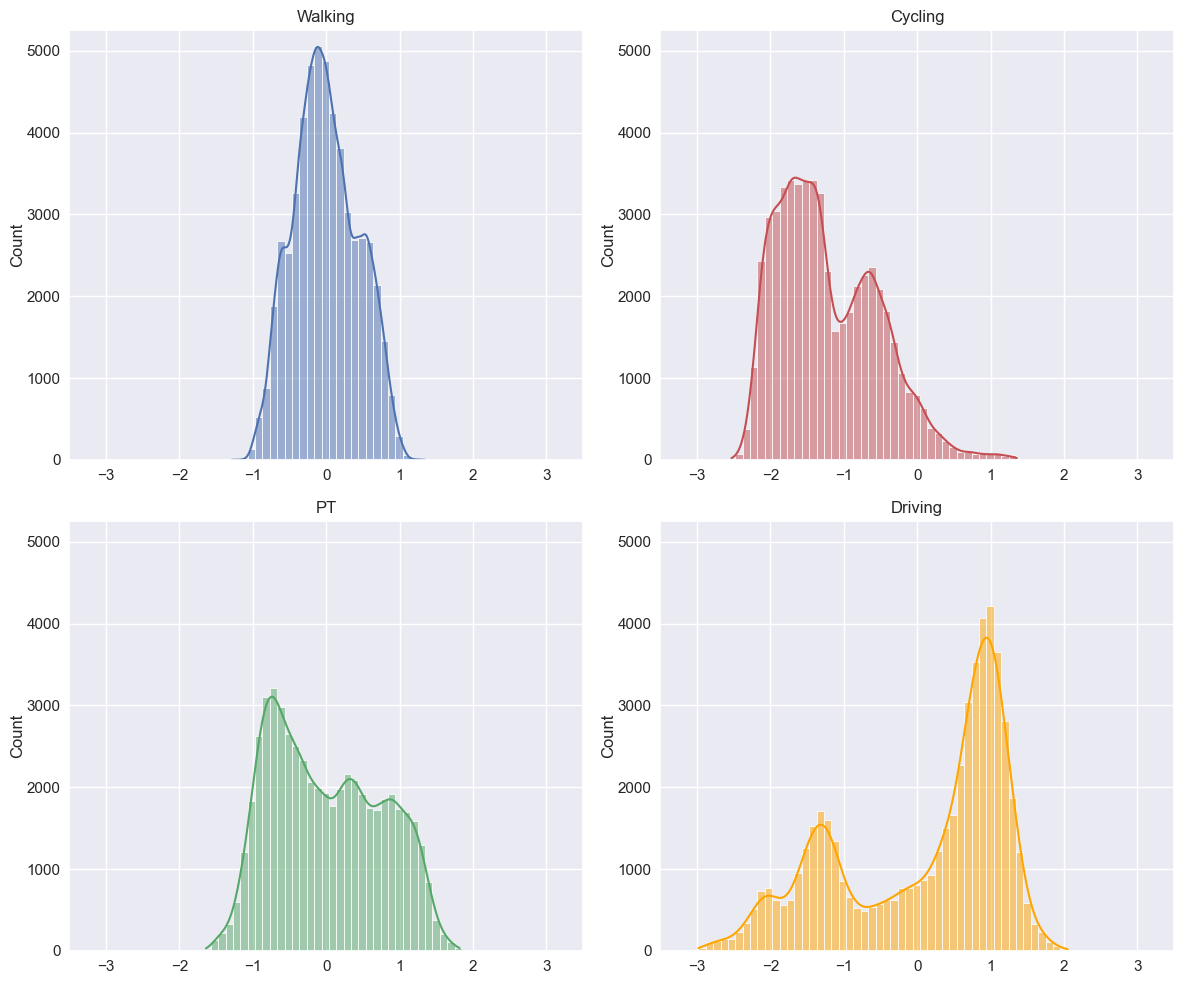

In [ ]:
plot_ind_spec_constant(socec_model, lgb_train_set, ['Walking', 'Cycling', 'PT', 'Driving'])

# References

Salvadé, Nicolas and Hillel, Tim, Rumboost: Gradient Boosted Random Utility Models. Available at SSRN: https://ssrn.com/abstract=4701222 or http://dx.doi.org/10.2139/ssrn.4701222

Hillel, T., Elshafie, M.Z.E.B., Jin, Y., 2018. Recreating passenger mode choice-sets for transport simulation: A case study of London, UK. Proceedings of the Institution of Civil Engineers - Smart Infrastructure and Construction 171, 29–42. https://doi.org/10.1680/jsmic.17.00018